In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
    )

#训练数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                         shuffle=True, num_workers=2)

#测试数据集
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                        shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


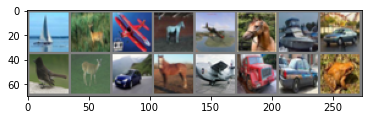

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    # 输入数据: torch.tensor [c, h, w]
    img = img / 2+0.5
    nping = img.numpy()
    nping = np.transpose(nping, (1,2,0)) # [h,w,c]
    plt.imshow(nping)
    
dataiter = iter(trainloader) #随机加载一个mini batch
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self): #定义神经网络结构, 输入数据 3x32x32
        super(Net, self).__init__()
        # 第一层（卷积层）
        self.conv1 = nn.Conv2d(3,6,3) #输入频道3， 输出频道6， 卷积3x3
        # 第二层（卷积层）
        self.conv2 = nn.Conv2d(6,16,3) #输入频道6， 输出频道16， 卷积3x3
        # 第三层（全连接层）
        self.fc1 = nn.Linear(16*28*28, 512) #输入维度16x28x28=12544，输出维度 512
        # 第四层（全连接层）
        self.fc2 = nn.Linear(512, 64) #输入维度512， 输出维度64
        # 第五层（全连接层）
        self.fc3 = nn.Linear(64, 10) #输入维度64， 输出维度10
    
    def forward(self, x): #定义数据流向
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = x.view(-1, 16*28*28)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        
        return x

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [12]:
%%time
train_loss_hist = []
test_loss_hist = []

for epoch in tqdm(range(20)):
    #训练
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        images, labels = data   
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels) # 计算损失
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if(i%250 == 0): #每250 mini batch 测试一次
            correct = 0.0
            total = 0.0

            net.eval()
            with torch.no_grad():
                for test_data in testloader:
                    test_images, test_labels = test_data
                    test_images = test_images.to(device)
                    test_labels = test_labels.to(device)
                    test_outputs = net(test_images)
                    test_loss = criterion(test_outputs, test_labels)

            train_loss_hist.append(running_loss/250)
            test_loss_hist.append(test_loss.item())
            running_loss=0.0


100%|██████████| 20/20 [12:55<00:00, 38.78s/it]

Wall time: 12min 55s


Text(0, 0.5, 'Loss')

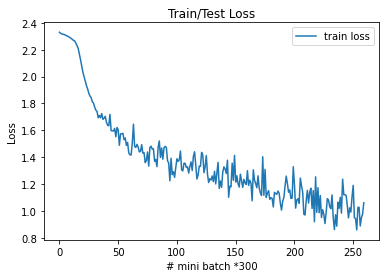

In [16]:
plt.figure()
plt.plot(test_loss_hist)
plt.legend(('train loss', 'test loss'))
plt.title('Train/Test Loss')
plt.xlabel('# mini batch *300')
plt.ylabel('Loss')

In [20]:
corrent = 0.0
total = 0.0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        corrent += (predicted == labels).sum()
        total += labels.size(0)
        
float(correct)/total
correct

0.0

In [ ]:
torch.save(net.state_dict(), './model.pt')
net_2.load_state_dict(torch.load('./model.pt'))